In [1]:
import sys
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts")
%matplotlib inline  
import analyseVCF as aVCF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import venn as vn
import displayPete as prf
import copy

In [2]:
## LOAD BED
BED_PATH = "/Users/peterpriestley/hmf/analyses/70-30sample/truthset/"
BED_FILE_NAME = "union13callableMQonlymerged_addcert_nouncert_excludesimplerep_excludesegdups_excludedecoy_excludeRepSeqSTRs_noCNVs_v2.19_2mindatasets_5minYesNoRatio.bed"
bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
bed.reverse()
truthBed = copy.deepcopy(bed)

reading BED file. . .



In [3]:
## LOAD TRUTH SET VCF
sampleNamesTruth = {'NA12878':'70-30truth'}
PathTruth = "/Users/peterpriestley/hmf/analyses/70-30sample/truthset/"
VCFFileTruth = "na12878-na24385-somatic-truth.vcf"
dfTruth = aVCF.loadVaraintsFromVCF(PathTruth,VCFFileTruth,sampleNamesTruth,True,truthBed)
dfTruth['chromPos']=dfTruth['chrom']+':'+dfTruth['pos']

reading vcf file. . .

reading VCF File line: 100000
reading VCF File line: 200000
reading VCF File line: 300000
reading VCF File line: 400000
reading VCF File line: 500000
reading VCF File line: 600000
reading VCF File line: 700000
reading VCF File line: 800000
reading VCF File line: 900000
reading VCF File line: 1000000
data frame loaded



In [4]:
print len(bed),len(truthBed)

3669832 159


In [8]:
## LOAD VCF
#sampleNames = {'/sample/output/GIAB_SOMATIC-MIX/somaticVariants/CPCT11111111R_CPCT11111111T/CPCT11111111R_CPCT11111111T_merged_somatics_snpEff_dbSNP_Cosmicv76' \
#                    :'melted'}
#VCFFileSample = "CPCT11111111R_CPCT11111111T_merged_somatics_snpEff_dbSNP_Cosmicv76_melted.vcf" 
sampleNames = {'CPCT11111111T.mutect':'mutect', \
               'CPCT11111111T.freebayes':'freebayes', \
               'TUMOR.strelka':'strelka', \
               'TUMOR.varscan':'varscan'}
PathSample = "/Users/peterpriestley/hmf/analyses/70-30sample/160401Schuberg/"
VCFFileSample = "combined.vcf"
df = aVCF.loadVaraintsFromVCF(PathSample,VCFFileSample,sampleNames,True,bed)
df['chromPos']=df['chrom']+':'+df['pos']
df['Truth']=df.chromPos.isin(dfTruth['chromPos'])

reading vcf file. . .

reading VCF File line: 100000
reading VCF File line: 200000
reading VCF File line: 300000
reading VCF File line: 400000
reading VCF File line: 500000
reading VCF File line: 600000
reading VCF File line: 700000
reading VCF File line: 800000
reading VCF File line: 900000
reading VCF File line: 1000000
reading VCF File line: 1100000
reading VCF File line: 1200000
reading VCF File line: 1300000
reading VCF File line: 1400000
reading VCF File line: 1500000
reading VCF File line: 1600000
reading VCF File line: 1700000
data frame loaded



In [47]:
df.head(1)

,chrom,pos,chromFrac,caller,ref,alleleTumor1,alleleTumor2,vennSegment,variantType,variantSubType,allelicFreq,chromPos,Truth
0,1,837214,1.003359,70-30truth,G,G,C,,SNP,,-1.0,1:837214,True


In [48]:
len(df)

4038421

In [59]:
df[(df.vennSegment == 'filterInvarscan-freebayes')  | (df.vennSegment == 'varscan-freebayes')].count()

chrom             4838
pos               4838
chromFrac         4838
caller            4838
ref               4838
alleleTumor1      4838
alleleTumor2      4838
vennSegment       4838
variantType       4838
variantSubType    4838
allelicFreq       4838
chromPos          4838
Truth             4838
dtype: int64

In [ ]:
#df[(df.variantType == 'SNP') & (df.ref.str.len()>1)].head(10)

In [ ]:
sorteddf = df.sort(['chromFrac'], ascending=1)
sorteddf['nextRef'] = sorteddf['ref'].shift(-2)
sorteddf['nextPos'] = sorteddf['pos'].shift(-2)
sorteddf['nextChrom'] = sorteddf['chrom'].shift(-2)
sorteddf['nextVT'] = sorteddf['variantType'].shift(-2)
sorteddf['nextAlleleTumor1'] = sorteddf['alleleTumor1'].shift(-2)
sorteddf['nextAlleleTumor2'] = sorteddf['alleleTumor2'].shift(-2)
sorteddf['nextVennSegment'] = sorteddf['vennSegment'].shift(-2)
sorteddf['lengthRef'] = sorteddf['ref'].str.len()
sorteddf['Dist2Next'] = -sorteddf['pos'].astype(int).diff(-2)

In [ ]:
sorteddf[sorteddf.pos == '42290477']

In [ ]:
overlapdf = sorteddf[(sorteddf['lengthRef']+0>sorteddf['Dist2Next']) & (sorteddf['Dist2Next']>0)]
overlapdf.head(20)

In [ ]:
filtereddf = overlapdf[(~overlapdf.vennSegment.isin(['varscan1','freebayes','strelka1'])) \
                       & (overlapdf.vennSegment.str.contains('varscan')) \
                       #& (~overlapdf.nextVennSegment.str.contains('varscan')) \
                       & (overlapdf.variantType == 'INDEL') \
                       #& (overlapdf.variantSubType == 'DELETE')
                       & (overlapdf.variantType == overlapdf.nextVT)]
filtereddf[['nextVennSegment','vennSegment','variantType','nextVT','Dist2Next','lengthRef','ref','alleleTumor2', \
            'nextRef','nextAlleleTumor2','variantSubType','chrom','pos']].count()

In [51]:
snpdf = df[(df.variantType == 'SNP') & (~snpdf.vennSegment.str.contains('filterIn'))]
snpPrivateDf =snpdf[(~snpdf.vennSegment.str.contains('-')) & (~snpdf.vennSegment.str.contains('Intersection'))]

In [52]:
pd.pivot_table(snpPrivateDf, values='pos', index=['caller'], columns=['Truth'], aggfunc='count')

Truth,False,True
caller,,
70-30truth,NaN,927343.0
freebayes,3634.0,1364.0
mutect,7590.0,18169.0
strelka,6663.0,16640.0
varscan,1275.0,5930.0


In [53]:
pd.pivot_table(snpdf, values='pos', index=['caller'], columns=['Truth'], aggfunc='count')

Truth,False,True
caller,,
70-30truth,NaN,927343.0
freebayes,6160.0,140257.0
mutect,28011.0,849551.0
strelka,29697.0,868887.0
varscan,16539.0,811210.0


In [75]:
pd.pivot_table(snpdf, values='pos', index=['vennSegment'], columns=['Truth'], aggfunc='count')

Truth,False,True
vennSegment,,
,NaN,927343.0
Intersection,6812.0,502784.0
filterInvarscan-freebayes,186.0,68.0
freebayes,3634.0,1364.0
mutect,7590.0,18169.0
mutect-filterInvarscan,70.0,510.0
mutect-filterInvarscan-freebayes,6.0,60.0
mutect-freebayes,98.0,936.0
mutect-strelka,16222.0,103574.0


In [ ]:
#plt.scatter(df[df.caller == 'mutect'].chromFrac, df[df.caller == 'mutect'].allelicFreq, s=10, c='b', marker="s")

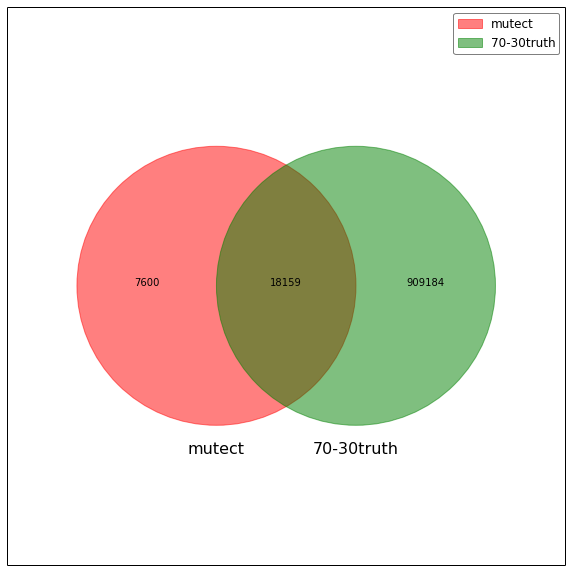

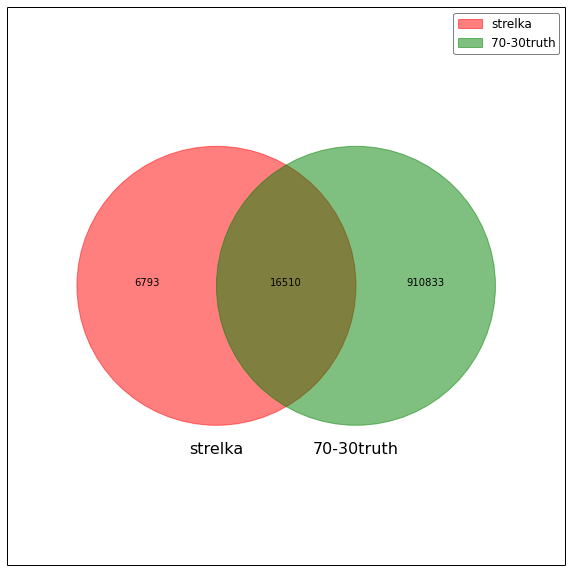

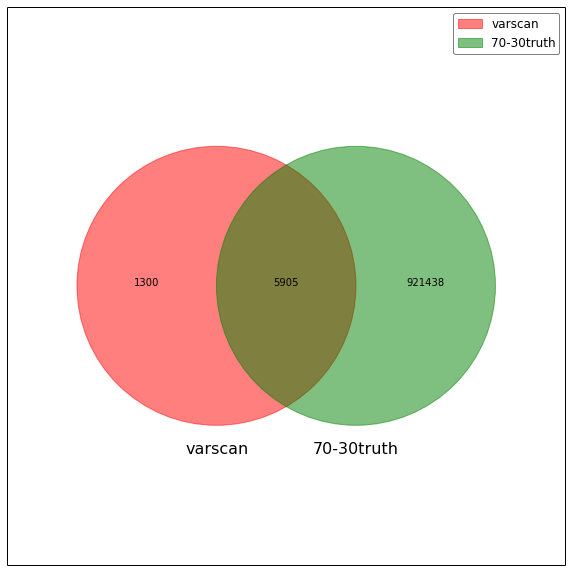

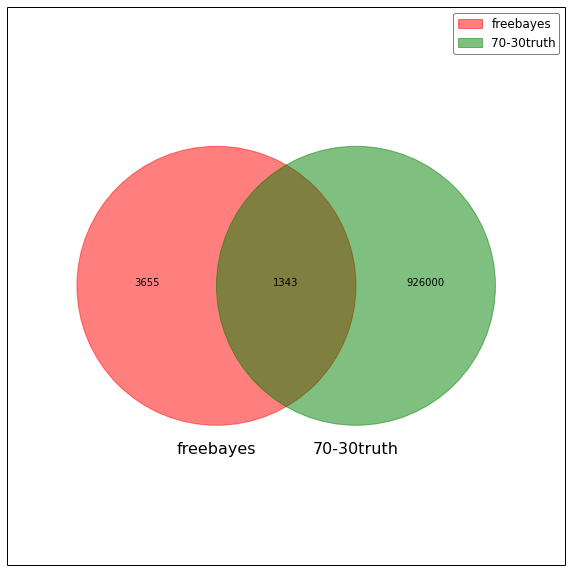

In [21]:
vn.venn([snpdf[snpdf.caller == 'mutect']['chromPos'], \
        snpdf[snpdf.caller == '70-30truth']['chromPos'] \
        ],['mutect','70-30truth'],figsize=(15,10))
vn.venn([snpdf[snpdf.caller == 'strelka']['chromPos'], \
        snpdf[snpdf.caller == '70-30truth']['chromPos'] \
        ],['strelka','70-30truth'],figsize=(15,10))
vn.venn([snpdf[snpdf.caller == 'varscan']['chromPos'], \
        snpdf[snpdf.caller == '70-30truth']['chromPos'] \
        ],['varscan','70-30truth'],figsize=(15,10))
vn.venn([snpdf[snpdf.caller == 'freebayes']['chromPos'], \
        snpdf[snpdf.caller == '70-30truth']['chromPos'] \
        ],['freebayes','70-30truth'],figsize=(15,10))

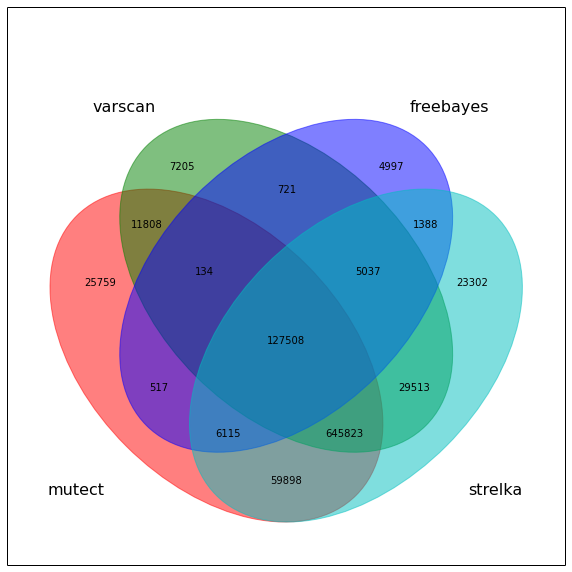

In [63]:
vn.venn([snpdf[snpdf.caller == 'mutect']['chromPos'], \
         snpdf[snpdf.caller == 'strelka']['chromPos'], \
        snpdf[snpdf.caller == 'varscan']['chromPos'], \
        snpdf[snpdf.caller == 'freebayes']['chromPos'] \
        ],['mutect','strelka','varscan','freebayes'],figsize=(15,10))

In [68]:
snpdf[snpdf.caller == 'strelka'][['vennSegment','caller','pos']].groupby(['vennSegment','caller']).agg('count')

,,pos
vennSegment,caller,
Intersection,strelka,127399
mutect-strelka,strelka,59898
mutect-strelka-filterInvarscan,strelka,1343
mutect-strelka-filterInvarscan-freebayes,strelka,109
mutect-strelka-freebayes,strelka,6115
mutect-strelka-varscan,strelka,644480
strelka,strelka,23303
strelka-filterInvarscan,strelka,380
strelka-filterInvarscan-freebayes,strelka,31


In [ ]:
snpdf[snpdf.caller == 'freebayes' ]['chromPos'].count()

In [ ]:
df[['caller','variantType','pos']].groupby(['variantType','caller']).agg('count')

In [ ]:
indeldf= df[(df.variantType == 'INDEL') & (~df.vennSegment.str.contains('filterIn'))]
vn.venn([indeldf[indeldf.caller == 'strelka']['chromPos'], \
        indeldf[indeldf.caller == 'varscan']['chromPos'], \
        indeldf[indeldf.caller == 'freebayes']['chromPos'] \
        ],['strelka','varscan','freebayes'],figsize=(15,10))

In [ ]:
#prf.display_for_pete(df, [prf.FormatType.ones_0,  
#                                      prf.FormatType.ones_0, 
#                                      prf.FormatType.ones_2, 
#                                      prf.FormatType.ones_0, 
#                                      prf.FormatType.ones_0, 
#                                      prf.FormatType.ones_2,
#                                         ], False)